In [1]:
import fix_yahoo_finance as yf  
import pandas as pd 
import numpy as np 
import networkx as nx
import scipy.special 
pd.core.common.is_list_like = pd.api.types.is_list_like 
import pandas_datareader as pdr 
from matplotlib import pyplot as plt
from datetime import date, datetime
import math
import random

from tools.comparisons import *
from tools.data_transform import *
from hypotheses.sign_statistics import *
from hypotheses.sign_tests import *

# from plotly.offline import iplot
# import plotly.graph_objs as go
# yf.pdr_override() 

/Users/stasyan/PycharmProjects/SignProcedure/venv/lib/python3.7/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance

/Users/stasyan/PycharmProjects/SignProcedure/venv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


##### Выкачиваем необходимые акции

In [0]:
# stocks_trend = ['AAL', 'ABBV', 'ACB', 'ALT', 'BIOC', 'BTC-USD', 'CCL', 'COST', 'DAL', 'GE', 
#                 'JNJ', 'JPM', 'KHC', 'KO', 'LMT', 'LUV', 'NVDA', 'SBUX', 'T', 'TEAM', 'TELL', 
#                 'TWTR', 'VOO', 'VZ', 'WFC', 'WMT', 'WORK', 'XOM',' ^TNX']

# stocks = ['AC','AI','AIR','MT','ATO'] 
# start = datetime.datetime(2019, 1, 1) 
# end = datetime.datetime(2020, 1, 1) 
# data = yf.download(stocks, start=start, end=end) 

In [2]:
stocks_article = ['A', 'AA', 'AAP', 'AAPL', 'AAWW', 'ACCO', 'ABG', 'ACWI', 'ADX']
start = datetime(2010, 11, 1) 
end = datetime(2011, 11, 1) 
data = yf.download(stocks_article, start=start, end=end) 

[*********************100%***********************]  9 of 9 completed


##### Проверяем и формируем данные

In [3]:
print(data.shape)
data.head()

(253, 54)


Adj Close                                                    \
                    A         AA        AAP      AAPL       AAWW    ABG   
Date                                                                      
2010-11-01  22.847473  29.224016  62.923355  9.387636  55.599998  14.57   
2010-11-02  23.051289  29.649498  62.738728  9.547504  58.869999  14.90   
2010-11-03  23.084167  29.492386  63.098240  9.653669  59.599998  15.00   
2010-11-04  23.662746  30.524843  63.943577  9.822487  60.150002  15.83   
2010-11-05  23.919165  31.422634  63.768677  9.787304  61.189999  15.81   

                                               Close  ...   Open   Volume  \
                ACCO       ACWI       ADX          A  ...    ADX        A   
Date                                                  ...                   
2010-11-01  5.589371  35.997765  5.305230  24.856939  ...  10.30  2885400   
2010-11-02  5.635411  36.342590  5.336223  25.078684  ...  10.33  2930000   
2010-11-03  5.616995  36.543068  5.351718  25.114449  ...  10.32  3352800   
2010-11-04  5.699869  37.369034  5.434373  25.743919  ...  10.41  3856600   
2010-11-05  6.022155  37.296864  5.470534  26.022890  ...  10.56  3263200   

                                                                         \
                  AA     AAP       AAPL    AAWW     ABG    ACCO    ACWI   
Date                                                                      
2010-11-01   7852500  555700  423889200  746000  202600  456300  176600   
2010-11-02   7370600  472000  433930000  448400  181200  223500  266900   
2010-11-03   8949600  555300  508348400  272200  105600  238400  241300   
2010-11-04  11662600  498100  642488000  407300  425800  298300  880200   
2010-11-05  13374600  647800  361253200  272800  191000  323100  286300   

                    
               ADX  
Date                
2010-11-01  254900  
2010-11-02  130800  
2010-11-03   70500  
2010-11-04  221300  
2010-11-05  102300  

[5 rows x 54 columns]

In [5]:
data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis='columns', inplace=True)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3936: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



Close                        ...                        
                    A         AA        AAP  ...  ACCO       ACWI    ADX
Date                                         ...                        
2010-11-01  24.856939  31.359150  64.760002  ...  6.07  44.889999  10.27
2010-11-02  25.078684  31.815720  64.570000  ...  6.12  45.320000  10.33
2010-11-03  25.114449  31.575420  64.940002  ...  6.10  45.570000  10.36
2010-11-04  25.743919  32.680801  65.809998  ...  6.19  46.599998  10.52
2010-11-05  26.022890  33.641998  65.629997  ...  6.54  46.509998  10.59

[5 rows x 9 columns]

### Сверяемся со статьей "Measures of uncertainty in market network analysis"

##### Данная матрица корреляций и лист акций из статьи




In [3]:
article_corr = [[1.0000, 0.7220, 0.4681, 0.4809, 0.6209, 0.5380, 0.6252, 0.6285, 0.7786, 0.7909], \
                [0.7220, 1.0000, 0.4395, 0.5979, 0.6381, 0.5725, 0.6666, 0.6266, 0.8583, 0.8640], \
                [0.4681, 0.4395, 1.0000, 0.3432, 0.3468, 0.2740, 0.4090, 0.4016, 0.4615, 0.4832], \
                [0.4809, 0.5979, 0.3432, 1.0000, 0.4518, 0.4460, 0.4635, 0.4940, 0.6447, 0.6601], \
                [0.6209, 0.6381, 0.3468, 0.4518, 1.0000, 0.5640, 0.5994, 0.5369, 0.7170, 0.7136], \
                [0.5380, 0.5725, 0.2740, 0.4460, 0.5640, 1.0000, 0.4969, 0.4775, 0.6439, 0.6242], \
                [0.6252, 0.6666, 0.4090, 0.4635, 0.5994, 0.4969, 1.0000, 0.6098, 0.7161, 0.7158], \
                [0.6285, 0.6266, 0.4016, 0.4940, 0.5369, 0.4775, 0.6098, 1.0000, 0.6805, 0.6748], \
                [0.7786, 0.8583, 0.4615, 0.6447, 0.7170, 0.6439, 0.7161, 0.6805, 1.0000, 0.9523], \
                [0.7909, 0.8640, 0.4832, 0.6601, 0.7136, 0.6242, 0.7158, 0.6748, 0.9523, 1.0000]]

article_stocks = ['A', 'AA', 'AAP', 'AAPL', 'AAWW', 'ABAX', 'ACCO', 'ABG', 'ACWI', 'ADX']

##### MST по данной матрице корреляций

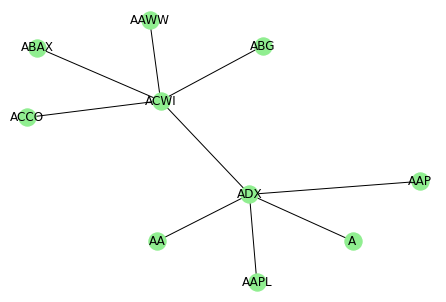

In [4]:
ref_MST1 = create_Kruskal_MST(article_corr, article_stocks)
nx.draw(ref_MST1, with_labels=True, node_color='lightgreen')

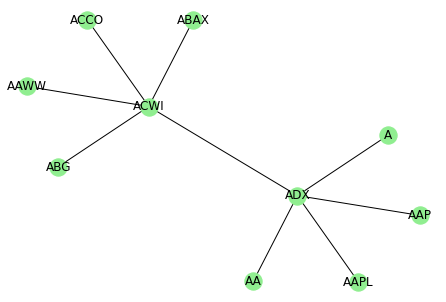

In [5]:
ref_MST2 = create_Prim_MST(article_corr, article_stocks)
nx.draw(ref_MST2, with_labels=True, node_color='lightgreen')

In [17]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Pearson', distr='normal')))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.003
observ = 100, same = 0.075
observ = 1000, same = 0.255
observ = 10000, same = 0.537
observ = 50000, same = 0.619


In [15]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Sign', distr='normal')))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.005
observ = 1000, same = 0.134
observ = 10000, same = 0.301
observ = 50000, same = 0.456


In [19]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Pearson', distr='Student', dof=1)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.001
observ = 1000, same = 0.001
observ = 10000, same = 0.0
observ = 50000, same = 0.0


In [20]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Sign', distr='Student', dof=1)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.005
observ = 1000, same = 0.123
observ = 10000, same = 0.261
observ = 50000, same = 0.471


In [5]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Pearson', distr='Student', dof=2)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.005
observ = 1000, same = 0.018
observ = 10000, same = 0.055
observ = 50000, same = 0.068


In [6]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Sign', distr='Student', dof=2)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.006
observ = 1000, same = 0.144
observ = 10000, same = 0.234
observ = 50000, same = 0.46


In [7]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Pearson', distr='Student', dof=3)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.014
observ = 1000, same = 0.116
observ = 10000, same = 0.198
observ = 50000, same = 0.304


In [8]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Sign', distr='Student', dof=3)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.004
observ = 1000, same = 0.145
observ = 10000, same = 0.275
observ = 50000, same = 0.459


In [6]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Pearson', distr='Student', dof=4)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.001
observ = 100, same = 0.022
observ = 1000, same = 0.157
observ = 10000, same = 0.325
observ = 50000, same = 0.519


In [7]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, measure='Sign', distr='Student', dof=4)))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.0
observ = 100, same = 0.003
observ = 1000, same = 0.144
observ = 10000, same = 0.298
observ = 50000, same = 0.469


#### Генерация случайных последовательностей из нормального распределния с данной матрицей корреляции и нулевым вектором математетического ожидания, построение MST по новым СВ и сравнение его с истиным MST

##### Сравниваем истиное MST с новым MST, полученными при разных кол-вах наблюдений

In [5]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, kind='Pearson')))

observ = 5, same = 0.0
observ = 10, same = 0.0
observ = 20, same = 0.002
observ = 100, same = 0.065
observ = 1000, same = 0.263
observ = 10000, same = 0.525
observ = 50000, same = 0.61


Значения из статьи: 0, 0, 0.005, 0.075, 0.258, 0.545, 0.647.     
Значит генерируем новые последовательность СВ и строим МСТ правильно (+ МСТ построенные по двум разным алгоритмам совпадают, так как ниразу не выпала -1)

In [6]:
for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
    print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST1, article_corr, observ, article_stocks, kind='Sign')))

observ = 5, same = -1
observ = 10, same = -1
observ = 20, same = -1
observ = 100, same = -1
observ = 1000, same = -1
observ = 10000, same = -1


KeyboardInterrupt: 

In [ ]:
corr = 

### То же самое, но для матрицы корреляции, полученной из выкачанных с yahoo данных 

##### Получаем доходности 9 акций

In [54]:
returns = []
for stock in data['Close']:
  returns.append(get_returns(data['Close'][stock]))
print(len(returns))
len(returns[0])

9


252

##### Получаем матрицу корреляции этих доходностей

In [55]:
ref_corr = np.corrcoef(returns)
ref_corr

array([[1.        , 0.75469845, 0.48316114, 0.48070892, 0.66463948,
        0.62522857, 0.62078544, 0.78750364, 0.78343383],
       [0.75469845, 1.        , 0.45575762, 0.60256718, 0.67953151,
        0.62264727, 0.67435238, 0.86658063, 0.86108024],
       [0.48316114, 0.45575762, 1.        , 0.35831691, 0.38759264,
        0.41819809, 0.41857366, 0.48025615, 0.49155804],
       [0.48070892, 0.60256718, 0.35831691, 1.        , 0.45091271,
        0.5025592 , 0.46677779, 0.6488523 , 0.66867308],
       [0.66463948, 0.67953151, 0.38759264, 0.45091271, 1.        ,
        0.54078982, 0.62224391, 0.73908196, 0.72558427],
       [0.62522857, 0.62264727, 0.41819809, 0.5025592 , 0.54078982,
        1.        , 0.58184976, 0.67233712, 0.6715842 ],
       [0.62078544, 0.67435238, 0.41857366, 0.46677779, 0.62224391,
        0.58184976, 1.        , 0.721803  , 0.71850341],
       [0.78750364, 0.86658063, 0.48025615, 0.6488523 , 0.73908196,
        0.67233712, 0.721803  , 1.        , 0.941782  ],


##### Строим MST по полученной матрице корреляции

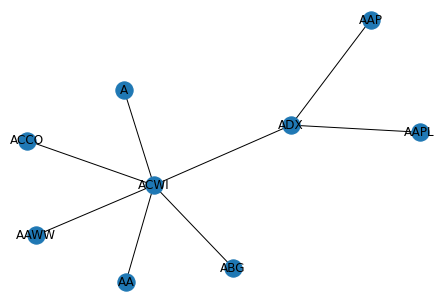

In [56]:
ref_MST = create_Kruskal_MST(ref_corr, stocks_article)
nx.draw(ref_MST, with_labels=True)

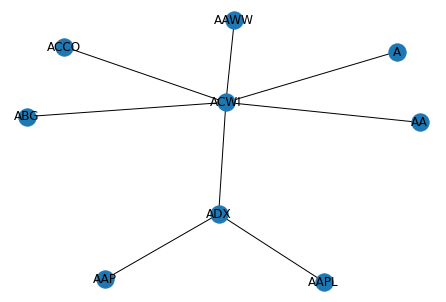

In [57]:
ref_MST = create_Prima_MST(ref_corr, stocks_article)
nx.draw(ref_MST, with_labels=True)

##### Сравниваем истиное MST с симулированными MST, полученными при разных кол-вах наблюдений

In [0]:
# for observ in [5, 10, 20, 100, 1000, 10000, 50000]:
#   print ('observ = {}, same = {}'.format(observ, compare_MSTs(ref_MST, ref_corr, observ, stocks_article)))

### То же самое, но через гипотезы

##### Получаем индикаторы доходностей

In [59]:
ret_inds = get_inds_matrix(returns)
print(len(ret_inds[0]))
np.array(ret_inds).shape

252


(9, 252)

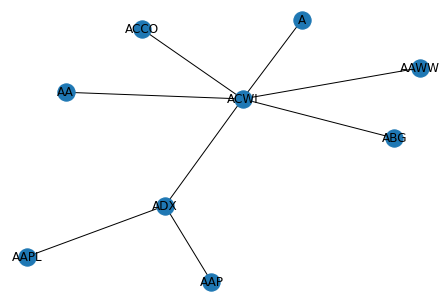

In [60]:
ref_MST = create_Prima_MST(np.corrcoef(returns), stocks_article)
nx.draw(ref_MST, with_labels=True)

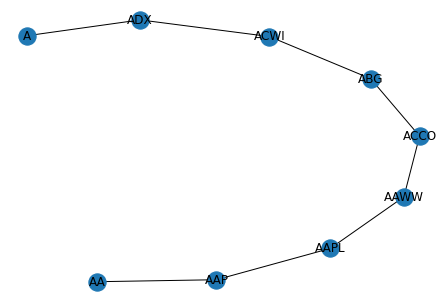

In [61]:
G = create_hypot_MST(ret_inds, stocks_article, 0.05)
nx.draw(G, with_labels=True)